## Exercise 5.8: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. 
* The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. 
* The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. 
* Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. 
* Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. 
* The rewards are −1 for each step until the car crosses the finish line. 
* If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. 
* Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. 
* To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. 

Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

<img src="racetrack.png" width="600">

In [6]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

CELL_TYPE_WALL = 0
CELL_TYPE_TRACK = 1
CELL_TYPE_GOAL = 2
CELL_TYPE_START = 3

class RaceTrack:
    def __init__(self, track, min_vel=0, max_vel=5):
        self.track = track
        self.wall_cells = np.argwhere(track == CELL_TYPE_WALL).tolist()
        self.goal_cells = np.argwhere(track == CELL_TYPE_GOAL).tolist()
        self.start_cells = np.argwhere(track == CELL_TYPE_START).tolist()
        self.min_vel = min_vel
        self.max_vel = max_vel
    
    @classmethod
    def from_csv(cls, file_path):
        
        file_path = os.path.join(os.getcwd(), file_path)
        
        track = genfromtxt(file_path, delimiter=',')
        
        # Flip the y-axis coordinates
        track = np.flip(track, axis=0)

        return cls(track) 
    
    def possible_actions(self, state):
        actions = [[a_y, a_x] for a_y in range(-1, 2) for a_x in range(-1, 2)]
        legal_actions = []

        _, _, v_y, v_x = state

        # Discard illegal actions
        for a in actions:
            a_y, a_x = a
            # Cannot go above speed limit in any x direction
            if v_x + a_x < self.min_vel or v_x + a_x > self.max_vel:
                continue
            # Cannot go above speed limit in any y direction
            if v_y + a_y < self.min_vel or v_y + a_y > self.max_vel:
                continue
            # Cannot noop
            if v_x + a_x == 0 and v_y + a_y == 0:
                continue
            legal_actions.append(a)
        return legal_actions
    
    def random_start_state(self):
        start_cell_idx = np.random.choice(len(self.start_cells))
        start_state = np.array(self.start_cells[start_cell_idx] + [0, 0])
        return start_state
    
    def apply_action(self, state, action):
        y_coord, x_coord, y_vel, x_vel = state
        a_y, a_x = action

        next_y_vel = y_vel + a_y
        next_x_vel = x_vel + a_x
        next_y_coord = y_coord + next_y_vel
        next_x_coord = x_coord + next_x_vel

        path = self.projected_path(
            (y_coord, x_coord), (next_y_vel, next_x_vel))

        if self.crossed_finish_line(path):
            return self.random_start_state(), 0, True
        if self.crossed_track_boundary(path):
            # if self.crossed_track_boundary([(next_y_coord, next_x_coord)]):
            return self.random_start_state(), -1, False

        return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), -1, False
        
    def projected_path(self, state, speed):
        # TODO: Should we only consider end state directly?
        y_coord, x_coord = state
        y_vel, x_vel = speed

        new_y_coord = y_coord + y_vel
        new_x_coord = x_coord + x_vel

        path = []
        for dy in range(min(y_coord, new_y_coord), max(y_coord, new_y_coord) + 1):
            for dx in range(min(x_coord, new_x_coord), max(x_coord, new_x_coord) + 1):
                path.append([dy, dx])
        return path
        
    def crossed_track_boundary(self, projected_path):
        for cell in projected_path:
            y, x = cell
            if y < 0 or y >= self.track.shape[0] or x < 0 or x >= self.track.shape[1] or cell in self.wall_cells:
                return True
        return False

    def crossed_finish_line(self, projected_path):
        for cell in projected_path:
            if cell in self.goal_cells:
                return True
        return False
        
    def draw(self, car_cell=None, path=[]):        
        colors = ['black', 'white', 'yellow', 'red']

        im = plt.imshow(self.track, cmap=ListedColormap(colors),
                        origin='lower', interpolation='none', animated=True)

        def rect(pos, edgecolor='k', facecolor='none'):
            r = plt.Rectangle(pos, 1, 1, facecolor=facecolor,
                              edgecolor=edgecolor, linewidth=2)
            plt.gca().add_patch(r)

        for i in range(self.track.shape[0]):
            for j in range(self.track.shape[1]):
                rect((j-0.5, i-0.5))

        if path:
            for cell in path:
                rect((cell[1]-0.5, cell[0]-0.5), edgecolor='g')

        if car_cell:
            rect((car_cell[1]-0.5, car_cell[0]-0.5),
                 edgecolor='g', facecolor='g')

        plt.gca().invert_yaxis()
        return im
        

In [7]:
rt = RaceTrack.from_csv("../racetracks/map1.csv")

In [8]:
path = rt.projected_path((6,8),(-2,2))
path

[[4, 8], [4, 9], [4, 10], [5, 8], [5, 9], [5, 10], [6, 8], [6, 9], [6, 10]]

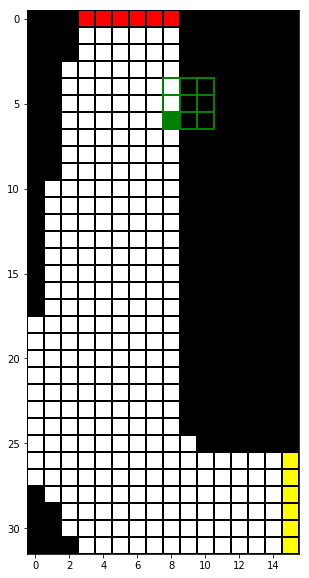

In [9]:
plt.figure(figsize=(10,10))
rt.draw((6,8),path)

In [10]:
import random
import math
from collections import defaultdict

class OnPolicyMonteCarloAgent:
    def __init__(self, track, gamma=1, n_episodes=100000, eps=0.5):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))

        # Initialize rewards dictionary
        self.R = defaultdict(list)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.zeros(self.Q.shape, dtype=float)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        for y_acc, x_acc in valid_actions:
                            self.pi[y_coord, x_coord, y_vel, x_vel,
                                    y_acc, x_acc] = 1/len(valid_actions)
                        
    def sample_random_action(self, state):
        # Sample action according to our eps-greedy policy
        # Ensure that probabilities we sample from sum to 1
        y_coord, x_coord, y_vel, x_vel = state

        actionprobs = self.pi[y_coord, x_coord, y_vel, x_vel]
        total_prob = np.sum(actionprobs)
        if not math.isclose(total_prob, 1, abs_tol=0.01):
            print(
                'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, state, self.pi[tuple(state)]))
            sys.exit(1)

        linear_idx = np.random.choice(
            actionprobs.size, p=actionprobs.ravel())
        a = np.unravel_index(linear_idx, actionprobs.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a  
            
    def generate_episode(self, pi):
        S = []
        A = []
        R = []

        # Select the initial state randomly
        start_state = self.track.random_start_state()
        S.append(start_state)

        terminated = False
        t = 0
        while not terminated:
            St = S[t]

            if t % 10000 == 0:
                print("Step: {}".format(t))

            a = self.sample_random_action(St)
            A.append(a)

            next_state, reward, terminated = self.track.apply_action(St, a)

            R.append(reward)
            S.append(next_state)
            t += 1

            # time.sleep(1)
        print("Terminated after {} steps".format(t))
        return S, A, R
    
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while not policy_stable or it < self.n_episodes:
            print('Iteration {}'.format(it))

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(self.pi)

            visited = set()

            # (b) Iterate over s,a pairs and update rewards and q-values
            old_Q = self.Q.copy()
            for t in range(len(S)-1):
                St, At, Rt = S[t], A[t], R[t]

                state_action_key = tuple(St.tolist() + list(At))

                # Skip to next step if we have aldready encountered this state, action pair
                if state_action_key in visited:
                    continue

                visited.add(state_action_key)

                # Calculate return that follows the first occurence of St, At
                G = 0
                for dt in range(len(S)-2, t-1, -1):
                    G = self.gamma * G + R[dt]

                self.R[state_action_key].append(G)
                self.Q[state_action_key] = np.average(self.R[state_action_key])

            # Q-diff: Credit to Joakim Blach Andersen
            Q_diff = abs(old_Q - self.Q)
            print('Q-diff: {}'.format(np.max(Q_diff)))

            # (c) Iterate over all states s and update the eps-greedy policy
            for s in S:
                y, x, y_vel, x_vel = s

                possible_actions = self.track.possible_actions(s)
                for a in possible_actions:
                    a_y, a_x = a

                    self.pi[y, x, y_vel, x_vel, a_y, a_x] = self.eps / \
                        len(possible_actions)

                # Get index of best action
                a_ys, a_xs = tuple(zip(*possible_actions))
                actionvals = self.Q[y, x, y_vel,
                                    x_vel, a_ys, a_xs]
                a_max_idx = np.argmax(actionvals)
                a_max_y, a_max_x = a_ys[a_max_idx], a_xs[a_max_idx]

                self.pi[y, x, y_vel, x_vel, a_max_y, a_max_x] += 1 - self.eps

                actionprobs = self.pi[y, x, y_vel, x_vel]
                total_prob = np.sum(actionprobs)
                if not math.isclose(total_prob, 1, abs_tol=0.01):
                    print(
                        'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, s, self.pi[y, x, y_vel, x_vel]))
                    sys.exit(1)
            
            # Check if convergence in case no number of episodes is set to 0
            if self.n_episodes is 0:
                if np.allclose(old_Q, self.Q, rtol=0.05):
                    print("Policy iteration converged after {} episodes".format(it))
                    policy_stable = True

            # Counter and update epsilon
            self.eps = 1/(1 + int(it/4))
            it += 1

In [11]:
agent = OnPolicyMonteCarloAgent(rt, n_episodes=1000)

In [ ]:
agent.policy_iteration()

Iteration 0
Step: 0
Terminated after 3974 steps
Q-diff: 3973.0
Iteration 1
Step: 0
Terminated after 445 steps
Q-diff: 1945.0
Iteration 2
Step: 0
Terminated after 8051 steps
Q-diff: 8036.0
Iteration 3
Step: 0
Terminated after 4924 steps
Q-diff: 4919.0
Iteration 4
Step: 0
Terminated after 5185 steps
Q-diff: 5156.0
Iteration 5
Step: 0
Terminated after 6569 steps
Q-diff: 6510.0
Iteration 6
Step: 0
Terminated after 2020 steps
Q-diff: 3435.5
Iteration 7
Step: 0
Terminated after 5070 steps
Q-diff: 5021.0
Iteration 8
Step: 0
Terminated after 7022 steps
Q-diff: 7017.0
Iteration 9
Step: 0
Terminated after 754 steps
Q-diff: 3771.0
Iteration 10
Step: 0
Terminated after 5235 steps
Q-diff: 5196.0
